# Heterogeneity Dataset Classification Project - Advanced ML SS 2016 
## *Bill Beluch, Elson Serrao, Prashanth Siddagangaiah, Ajay Jason Andrade*

# Table of Contents
1. [Initial Data Analysis](#Initial-Data-Analysis)
    2. [Summary of Data](#Summary-of-Data)
    3. [Parsing the Data](#Parsing-the-Data)
    4. [Exploratory Analysis](#Exploratory-Analysis)
    5. [Feature Extraction](#Feature-Extraction)
    6. [Ground Truth Analysis](#Ground-Truth-Analysis)
2. [Offline Classification](#Offline-Classification)
    1. [Classify on Mean](#Classify-on-Mean)
    2. [Classify on Mean and Standard Deviation](#Classify-on-Mean-and-Standard-Deviation)
        1. [Nearest Neigbors: optimal neighbor set size](#Nearest-Neigbors:-optimal-neighbor-set-size)
    3. [Results and Evaluation](#Results-and-Evaluation)
        1. [Algorithm Accuracy](#Algorithm-Accuracy)
        2. [Confusion Matrix](#Confusion-Matrix)
        3. [Distribution of CV Scores](#Distribution-of-CV-Scores)
        4. [Classification Performance vs CV Size](#Classification-Performance-vs-CV-Size)
3. [Online Classification](#Online-Classification)
    1. [Data Shuffle](#Data-Shuffle)
    2. [Classify on Standard Deviation and Mean](#Classify-on-Standard-Deviation-and-Mean)
    3. [Results/Evaluation](#Results/Evaluation)
        1. [Accuracy Over Training Lifetime](#Accuracy-Over-Training-Lifetime)
        2. [Linear SVM Accuracy](#Linear-SVM-Accuracy)
4. [Conclusion](#Conclusion)  
    1. [Future Work](#Future-Work)
5. [Citations and Links](#Citations-and-Links)
    
    

## Initial Data Analysis
### Summary of Data
The Heterogeneity Activity Recognition Data Set consists of accelerometer and gyroscope readings from a variety of mobile phones and smart watches, obtained while users were doing one of six basic physical activities: stand, sit, walk, bike, climb up stairs, climb down stairs.  In total, 9 users performed each of the activities for 5 minutes.  Due to the large number of devices strapped to each user (8 smart phones, 4 smart watches), and the high frequency of the recordings, the datasets are relatively large: the phone data consists of approximately 13 million records, whereas the watch data consists of approximately 3.5 million records.  Further information about the dataset can be found at the appropriate page on the UCI machine learning repository and the accompanying publication.  

Dataset source:  
http://archive.ics.uci.edu/ml/datasets/Heterogeneity+Activity+Recognition

Publication:  
http://dl.acm.org/citation.cfm?doid=2809695.2809718  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import math 
from datetime import datetime 
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, neighbors, svm, linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")
sns.set(font_scale=3)
%matplotlib inline

### Parsing the Data
The first step in our data exploration is to figure out what the data looks like, and devise an effective parsing strategy.  As the number of records is very large, the assumption is that some type of feature extraction will be performed to reduce the number of records to facilitate reasonable training types for classification algorithms.  

In the following blocks of code, the phones accelerometer file will be read into memory, and a quick examination of the dataset is undertaken.  

In [2]:
filename = './activity_rec/Watch_accelerometer.csv'
filename2 = './activity_rec/Watch_gyroscope.csv'
filename3 = './activity_rec/Phones_accelerometer.csv'
filename4 = './activity_rec/Phones_gyroscope.csv'

In [3]:
! head -n 2 ./activity_rec/Phones_accelerometer.csv

Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,1424696633908,1424696631913248572,-5.958191,0.6880646,8.135345,a,nexus4,nexus4_1,stand


In [4]:
# function to convert the timestamp in the Arrival_Time column to a human readable datetime
def dateparse (time):
    time_p = time[:10] + '.' + time[10:]
    return datetime.fromtimestamp(float(time_p))

In [5]:
# read in the file, selectively excluding the columns Index, Creation_Time, and Model
# note this can take some time, and will take up some RAM
phone_acc = pd.read_csv(filename3, parse_dates=[0], infer_datetime_format=True, date_parser=dateparse, 
                          header=0, usecols=[1,3,4,5,6,8,9])

In [6]:
def get_acc(row):
    """Returns the actual acceleration from the x,y,z values of an accelerometer record."""
    return math.sqrt(row['x']**2 + row['y']**2 + row['z']**2)

### Exploratory Analysis
In order to get a better sense of the raw data, we can look at how the acceleration readings change over time for the various activities.  To remove noise between users/devices, we look at only one user and one device.  

In [7]:
# create a temporary dateframe of only one user and one device 
tmp = phone_acc[(phone_acc['User'] == 'g') & (phone_acc['Device'] == 'nexus4_1')]
# create an additional column with the actual acceleration
tmp['acc'] = tmp.apply(get_acc, axis=1)
tmp.head()

/home/bill/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Arrival_Time,x,y,z,User,Device,gt,acc
8574740,2015-02-23 11:18:50.639,-2.275757,-2.054123,8.883972,g,nexus4_1,null,9.398056
8574741,2015-02-23 11:18:55.001,-2.148407,1.661636,9.839691,g,nexus4_1,stand,10.207654
8574742,2015-02-23 11:18:55.006,-2.138886,1.700913,9.869446,g,nexus4_1,stand,10.240796
8574743,2015-02-23 11:18:55.010,-2.125794,1.689011,9.846832,g,nexus4_1,stand,10.214297
8574744,2015-02-23 11:18:55.020,-2.147217,1.706863,9.859924,g,nexus4_1,stand,10.234355


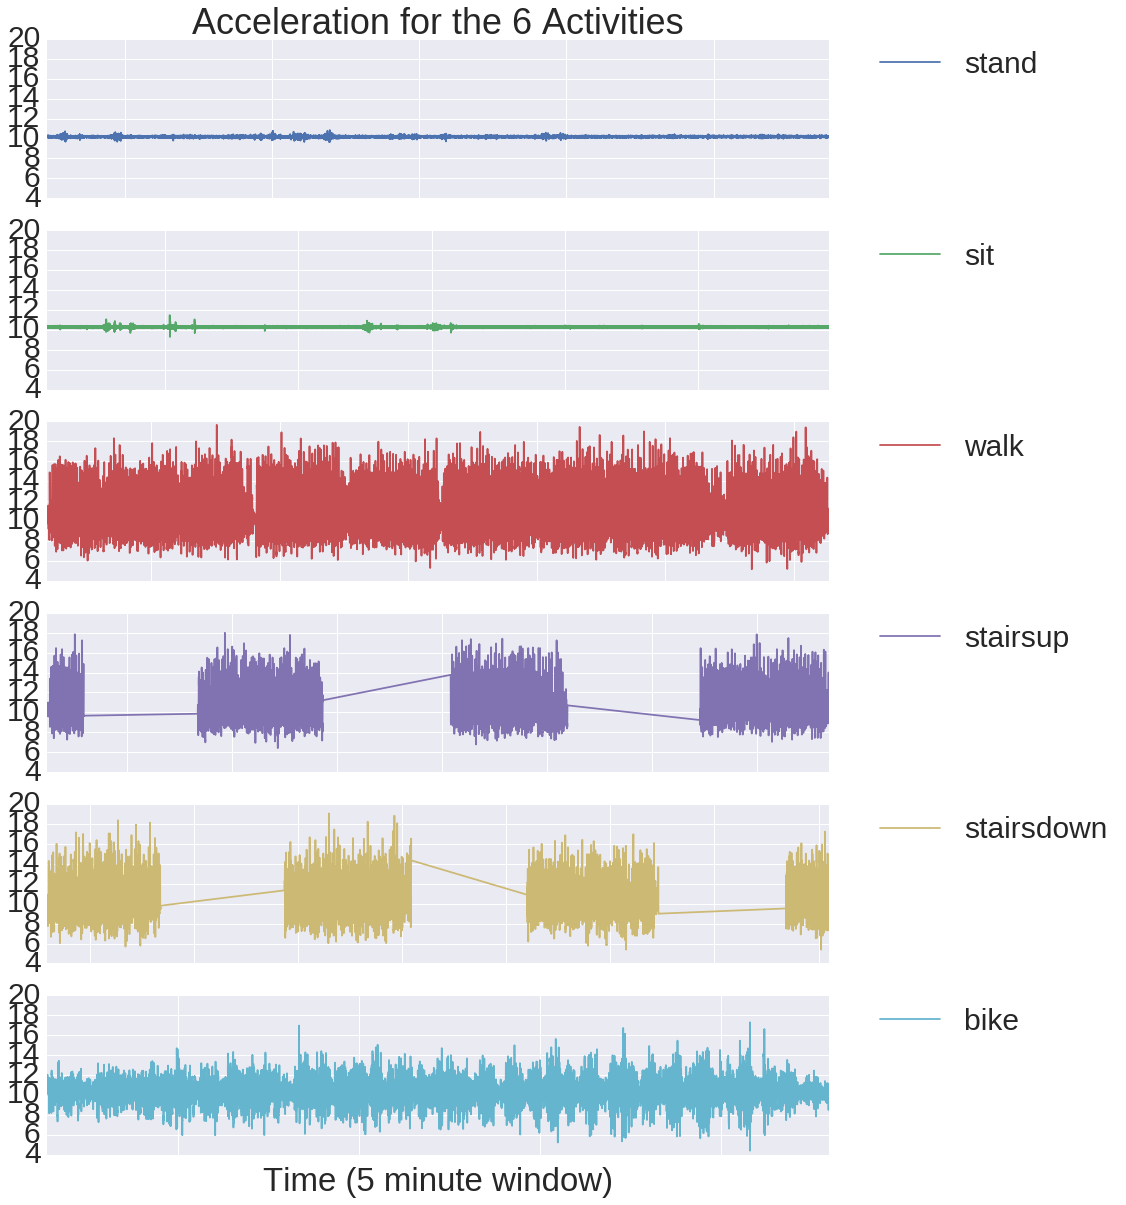

In [8]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(14,20))
l1 = tmp[tmp['gt'] == 'stand']['acc'].plot(ax=ax1, color = sns.color_palette()[0], label='stand')
l2 = tmp[tmp['gt'] == 'sit']['acc'].plot(ax=ax2, color = sns.color_palette()[1], label='sit')
l3 = tmp[tmp['gt'] == 'walk']['acc'].plot(ax=ax3, color = sns.color_palette()[2], label='walk')
l4 = tmp[tmp['gt'] == 'stairsup']['acc'].plot(ax=ax4, color = sns.color_palette()[3], label='stairsup')
l5 = tmp[tmp['gt'] == 'stairsdown']['acc'].plot(ax=ax5, color = sns.color_palette()[4], label='stairsdown')
l6 = tmp[tmp['gt'] == 'bike']['acc'].plot(ax=ax6, color = sns.color_palette()[5], label='bike')

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.axes.xaxis.set_ticklabels([])
    ax.set_xlabel('')
    ax.set_ylim([4, 20])
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
ax6.set_xlabel('Time (5 minute window)')
ax1.set_title('Acceleration for the 6 Activities')

The above plot shows that each of the six activities have relatively distinct traces over the five minute intervals.  As expected, the accelerations for standing and sitting are relatively constant (it is assumed that the value ~10 is zero acceleration), although standing seems to have slightly more fluctuation.  Walking displays a constant oscillation centered around ~11, and looks similar to the patterns seen in the stairs climbing.  The above graph shows that the stairsdown and stairsup were actually performed together - thus instead of a constant 5 minutes of climbing up, the user climbed up for 1 minute, then down for 1 minute, etc.  This also explains why the graphs for stairsclimbing span approximately 10 minutes.  Biking displays an oscillation as well, but with smaller values than the walking varieties.  

Based on the above traces, standin/sitting and walking/stairs climbing seem to have the most similar traces.  

### Feature Extraction

In the provided dataset, we have chosen to ignore the columns of user, model, and device, as we would like the results to be generalizable to other users and devices potentially not in the dataset.  We also have chosen to use the arrival time for our analysis, as opposed to the creation time.  This is more or less a random choice - the difference between the two times and an analysis thereof can be found in the publication mentioned in the introduction.  

The above traces show that the actual acceleration values of a single reading(and presumably also gyroscope values) are likely not as informative as the change in values that is occuring over a given time window.  Thus, in order to both extract relevant features and make the algorith training more efficient, we decided to sample the data in two second intervals.  In the below code, both the gyroscope phone data is parsed into memory, and from both files we group the records into 2s intervals, and extract the mean and standard deviation of these intervals as our features.  

In [9]:
phone_acc = phone_acc.set_index('Arrival_Time')
# subsample in 2 second intervals
rs= phone_acc.resample('2S')

# extract the means and standard deviations of the x,y and z columns
df1 = rs['x'].agg({'x_mean': np.mean, 'x_std': np.std})
df2 = rs['y'].agg({'y_mean': np.mean, 'y_std': np.std})
df3 = rs['z'].agg({'z_mean': np.mean, 'z_std': np.std})
# obtain the ground truth label for the interval
df4 = rs['gt'].max()
# clear the intial df from memory as it is quite large 
del phone_acc
del tmp
# combine the columns obtained above
result = pd.concat([df1, df2, df3, df4], axis=1)
# remove null values (created during the time subsampling)
result = result.dropna()
result.head()

,x_mean,x_std,y_std,y_mean,z_std,z_mean,gt
Arrival_Time,,,,,,,
2015-02-23 11:18:52,-2.620198,0.374935,0.260476,1.804099,0.249648,9.171505,stand
2015-02-23 11:18:54,-2.319132,0.344158,0.244359,1.762942,0.296751,9.351991,stand
2015-02-23 11:18:56,-2.203278,0.232428,0.201152,1.667375,0.255857,9.457591,stand
2015-02-23 11:18:58,-2.210815,0.248567,0.384416,1.396722,0.277554,9.506046,stand
2015-02-23 11:19:00,-2.358816,0.437003,0.631597,1.589100,0.406420,9.339257,stand


In [11]:
# this block performs the same operations as seen in the preceding blocks but for the gyroscope data
# code comments can be seen in the above block 

# note this can take some time, and will take up some RAM
phone_gyr = pd.read_csv(filename4, parse_dates=[0], infer_datetime_format=True, date_parser=dateparse, 
                          header=0, usecols=[1,3,4,5,9])
phone_gyr = phone_gyr.set_index('Arrival_Time')
phone_rs= phone_gyr.resample('2S')
df1 = phone_rs['x'].agg({'x_mean': np.mean, 'x_std': np.std})
df2 = phone_rs['y'].agg({'y_mean': np.mean, 'y_std': np.std})
df3 = phone_rs['z'].agg({'z_mean': np.mean, 'z_std': np.std})
df4 = phone_rs['gt'].max()
del phone_gyr

result_g = pd.concat([df1, df2, df3, df4], axis=1)
result_g = result_g.dropna()
result_g = result_g.drop('gt', axis=1)
result_g.head()

,x_mean,x_std,y_std,y_mean,z_std,z_mean
Arrival_Time,,,,,,
2015-02-23 11:18:52,-0.001909,0.012918,0.040626,0.007967,0.036098,0.014125
2015-02-23 11:18:54,0.003666,0.033779,0.033082,-0.005462,0.025169,-0.006331
2015-02-23 11:18:56,0.000449,0.004426,0.011357,0.004189,0.018514,-0.005674
2015-02-23 11:18:58,-0.015847,0.040999,0.052462,-0.008524,0.103501,-0.058404
2015-02-23 11:19:00,0.020782,0.062217,0.097599,0.019391,0.194427,0.036813


In [12]:
# the acceleromter and gyroscope data are merged to create records containing both gyr and acc data
merge = result.merge(result_g, left_index=True, right_index=True, suffixes=('_acc', '_gyr'))

In [13]:
# the new dataset is written to disk to avoid having to reread and subsample the data repeatedly
# merge.to_csv('resampled_phone_acc+gyr.csv', sep=',')

### Ground Truth Analysis 
The below block shows what our subsampled data looks like - each record has twelve potential features (excluding the time information).  As a brief aside, we look at the distribution of ground truth labels, expecting them to be roughly equal considering each activity was performed for 5 minutes.  

In [14]:
data = pd.read_csv('resampled_phone_acc+gyr.csv', header=0)
data.head()

,Arrival_Time,x_std_acc,x_mean_acc,y_std_acc,y_mean_acc,z_std_acc,z_mean_acc,gt,x_std_gyr,x_mean_gyr,y_std_gyr,y_mean_gyr,z_std_gyr,z_mean_gyr
0,2015-02-23 11:18:52,0.374935,-2.620198,0.260476,1.804099,0.249648,9.171505,stand,0.012918,-0.001909,0.040626,0.007967,0.036098,0.014125
1,2015-02-23 11:18:54,0.344158,-2.319132,0.244359,1.762942,0.296751,9.351991,stand,0.033779,0.003666,0.033082,-0.005462,0.025169,-0.006331
2,2015-02-23 11:18:56,0.232428,-2.203278,0.201152,1.667375,0.255857,9.457591,stand,0.004426,0.000449,0.011357,0.004189,0.018514,-0.005674
3,2015-02-23 11:18:58,0.248567,-2.210815,0.384416,1.396722,0.277554,9.506046,stand,0.040999,-0.015847,0.052462,-0.008524,0.103501,-0.058404
4,2015-02-23 11:19:00,0.437003,-2.358816,0.631597,1.589100,0.406420,9.339257,stand,0.062217,0.020782,0.097599,0.019391,0.194427,0.036813


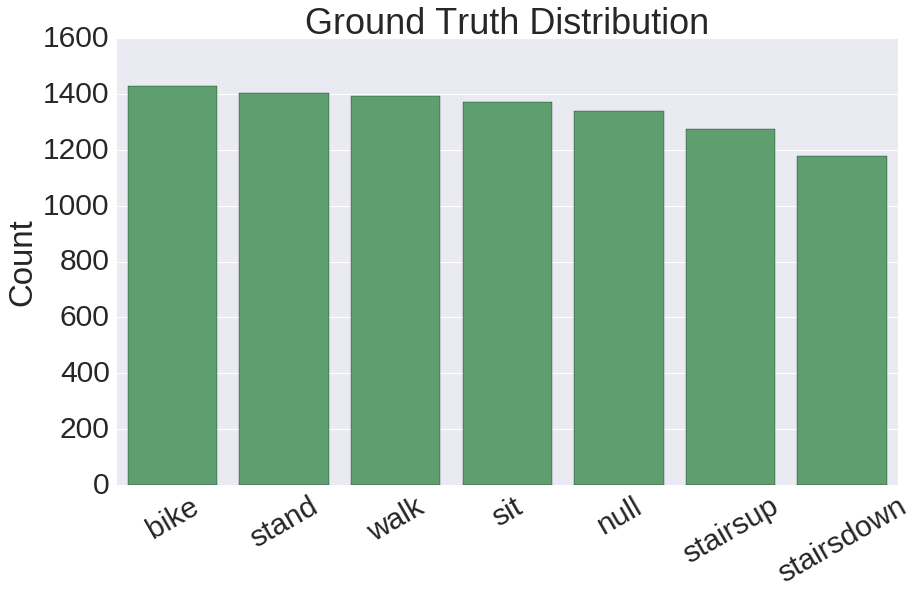

In [15]:
fig = plt.figure(figsize=(14,8))
counts = pd.DataFrame(data['gt'].value_counts())
ax = sns.barplot(x=counts.index, y="gt", data=counts, color=sns.color_palette()[1])
ax.set_ylabel('Count')
plt.xticks(rotation=30)
ax.set_title('Ground Truth Distribution')

The above chart shows that the output classes are roughly equally distributed.  The stair climbing classes have slightly less data than the other classes - this is likely due to the fact that the activities were not performed sequentially for five minutes, but rather alternated in 1 minute blocks as discussed above.  Additionally, there is a 'null' class containing ~1350 records, corresponding to records with no ground truth label.  For the rest of the analysis, these records are removed from the dataset.  

In [16]:
# remove the ground truth 'null' records
data = data[data['gt'] != 'null']
data['gt'].value_counts()

bike          1429
stand         1406
walk          1393
sit           1372
stairsup      1275
stairsdown    1179
Name: gt, dtype: int64

## Offline Classification 
After the initial analysis and feature extraction, we move to classification tasks.  As our subsampled data contains only ~8000 records, offline in-memory classification is very feasible and rather quick.  We briefly examine the use of four different algorithms: random forests, gaussian Naive Bayes, SVMs (both rbf and linear kernel), and nearest neighbors.  For all classification tasks, 10-fold cross validation is performed, and the performance metric is defined as the percentage of correctly predicted classes in the test set.  Generally, the output below the classifier code blocks is the mean accuracy of the ten cross validation folds.  

### Classify on Mean 
For the first run, we look at classification using only the mean values of the x, y, and z readings from both the accelerometer and gyroscope.  

In [17]:
# obtain the relevant features for classification
y = data['gt'].values
X = data[['x_mean_acc', 'y_mean_acc', 'z_mean_acc', 'x_mean_gyr', 'y_mean_gyr', 'z_mean_gyr']].values

# split the data into a training and test set for later use - for most CV the built in function from scikit learn is used,
# however to generate a later confusion matrix an explicit split is necessary.  10% test size is used as to be comparable
# to 10-fold cross validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# list to hold the accuracies of the various algorithms
cv_scores = []

In [18]:
# Random forests
clf = RandomForestClassifier(n_estimators=10)
scores = cross_validation.cross_val_score(clf, X, y, cv=10)
tuples = [('Random Forest', 'mean', score) for score in scores]
cv_scores += tuples
scores.mean()

0.75335627773173786

In [19]:
# Naive Bayes
gnb = GaussianNB()
scores = cross_validation.cross_val_score(gnb, X, y, cv=10)
tuples = [('Naive Bayes', 'mean', score) for score in scores]
cv_scores += tuples
scores.mean()

0.49176824655779383

In [20]:
# SVM (rbf, linear)
kernels = ['rbf', 'linear']
for kernel in kernels:
    clf = svm.SVC(kernel=kernel)
    scores = cross_validation.cross_val_score(clf, X, y, cv=10)
    print(kernel, scores.mean())
    tuples = [('SVM(' + kernel + ')', 'mean', score) for score in scores]
    cv_scores += tuples

rbf 0.552342290721
linear 0.450938713532


In [21]:
clf = neighbors.KNeighborsClassifier(1)
scores = cross_validation.cross_val_score(clf, X, y, cv=10)
tuples = [('Nearest Neighbor', 'mean', score) for score in scores]
cv_scores += tuples
scores.mean()

0.70227690442771951

### Classify on Mean and Standard Deviation
For the next set of classification, we use both the means and the standard deviations.  

In [22]:
# get a new view of our dataframe, this time including standard deviation also
y = data['gt'].values
X = data.drop(['gt', 'Arrival_Time'], axis=1).values

In [23]:
# random forest
clf = RandomForestClassifier(n_estimators=10)
scores = cross_validation.cross_val_score(clf, X, y, cv=10)
tuples = [('Random Forest', 'mean + std', score) for score in scores]
cv_scores += tuples

# also run a short block to generate a confusion matrix for one fold
clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
confuse_acc = (len(predicted[predicted==y_test]) / float(len(y_test)))
matrix = confusion_matrix(y_test, predicted, np.unique(y))
scores.mean()

0.92929742227161749

In [24]:
# again look at random forests, this time getting results from various cross-validation sizes
cvs = [5, 10, 20, 50, 100]
cv_scores2 = []

for cv in cvs:
    clf = RandomForestClassifier(n_estimators=10)
    scores = cross_validation.cross_val_score(clf, X, y, cv=cv)
    tuples = [('Random Forest', cv, score) for score in scores]
    cv_scores2 += tuples



In [25]:
# Naive Bayes
gnb = GaussianNB()
scores = cross_validation.cross_val_score(gnb, X, y, cv=10)
tuples = [('Naive Bayes', 'mean + std', score) for score in scores]
cv_scores += tuples
scores.mean()

0.72133192766838483

In [26]:
# Naive Bayes with changing cross validation size
cvs = [5, 10, 20, 50, 100]

for cv in cvs:
    gnb = GaussianNB()
    scores = cross_validation.cross_val_score(gnb, X, y, cv=cv)
    tuples = [('Naive Bayes', cv, score) for score in scores]
    cv_scores2 += tuples

In [27]:
# SVMs
kernels = ['rbf', 'linear']
for kernel in kernels:
    clf = svm.SVC(kernel=kernel)
    scores = cross_validation.cross_val_score(clf, X, y, cv=10)
    tuples = [('SVM(' + kernel + ')', 'mean + std', score) for score in scores]
    cv_scores += tuples
    print(kernel, scores.mean())

rbf 0.919878525974
linear 0.882021605331


In [29]:
# KNN
clf = neighbors.KNeighborsClassifier(1)
scores = cross_validation.cross_val_score(clf, X, y, cv=10)
tuples = [('Nearest Neighbor', 'mean + std', score) for score in scores]
cv_scores += tuples
scores.mean()

0.93979652355121801

#### Nearest Neigbors: optimal neighbor set size
As a brief aside, we look at which neighbor size gives the best results.  As the below table shows, a neighbor set size of 1 gives the best results.  

In [31]:
scores_t = []
for x in [1, 2, 3, 4, 5, 10, 20, 50]:
    clf = neighbors.KNeighborsClassifier(x)
    scores = cross_validation.cross_val_score(clf, X, y, cv=10)
    scores_t.append((x, scores.mean()))
    
pd.DataFrame(scores_t, columns=['K', 'Accuracy'])

,K,Accuracy
0,1,0.939797
1,2,0.938068
2,3,0.936954
3,4,0.938931
4,5,0.933713
5,10,0.925772
6,20,0.903058
7,50,0.866463


### Results and Evaluation
The below sections and figures analyze the results of the above classification algorithms.  

In [32]:
# generate dataframe from the various cross validation scores 
df = pd.DataFrame(cv_scores, columns=['algo', 'features', 'score'])
df.head()

,algo,features,score
0,Random Forest,mean,0.705446
1,Random Forest,mean,0.695545
2,Random Forest,mean,0.719950
3,Random Forest,mean,0.770471
4,Random Forest,mean,0.722084


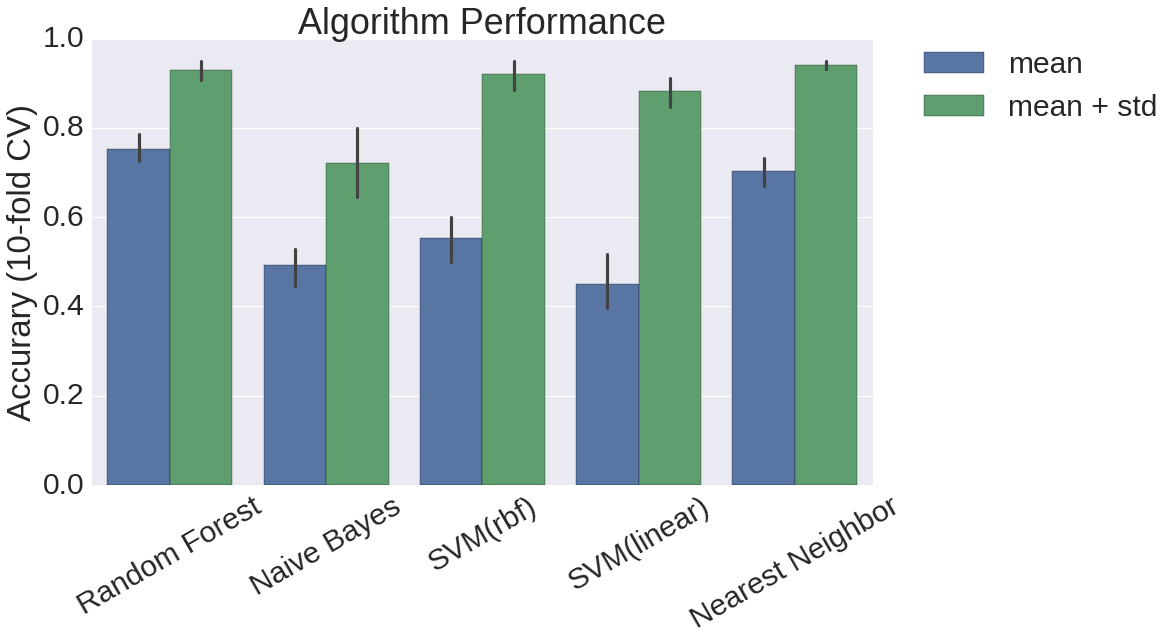

In [33]:
fig = plt.figure(figsize=(14,8))
ax = sns.barplot(x="algo", y="score", hue="features", data=df)
ax.set_ylabel('Accurary (10-fold CV)')
ax.set_xlabel('')
plt.xticks(rotation=30)
ax.set_title('Algorithm Performance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Algorithm Accuracy
As the above chart shows, all of the algorithms perform significantly better when using the standard deviation informatin in addition to just the mean values.  All of the algorithms except for Naive Bayes approach 90-95% accuracy, compared to approximately 60% accuracy when using only the mean.  This intuitively makes sense considering the spreads seen in the initial traces.  Naive Bayes underperforms likely due to the conditional independence assumptions made, which are certainly not true in our data set, and the relative simplicity of the algorithm.  In addition, one notices that the standard deviation of the Naive Bayes cross validation sets (the bars above are averages of the 10 separate accuracies), is rather high.  This also makes sense considering the algorithm - depending on the split of the data, the calculated probabilities could vary leading to different results.  Obviously the smaller the dataset, the more extreme this problem becomes.  

In [34]:
confusion_matrix = pd.DataFrame(matrix, columns=np.unique(y))
confusion_matrix.index = np.unique(y)
print(confuse_acc)
confusion_matrix

0.8511166253101737


,bike,sit,stairsdown,stairsup,stand,walk
bike,123,0,5,5,8,5
sit,1,114,0,0,0,0
stairsdown,10,0,73,2,5,20
stairsup,1,0,3,117,1,3
stand,4,0,1,3,143,6
walk,9,0,16,4,8,116


#### Confusion Matrix
The above table is a confusion matrix for one 90%/10% train/test split using random forests on the mean and standard deviation data.  The total accuracy on this set is printed above the table.  The matrix shows that the most misclassifications are concerning walk and stairsdown, in both directions (20 and 16 misclassifications).  Sitting is the most consistently classified output, being very rarely confused with biking.  

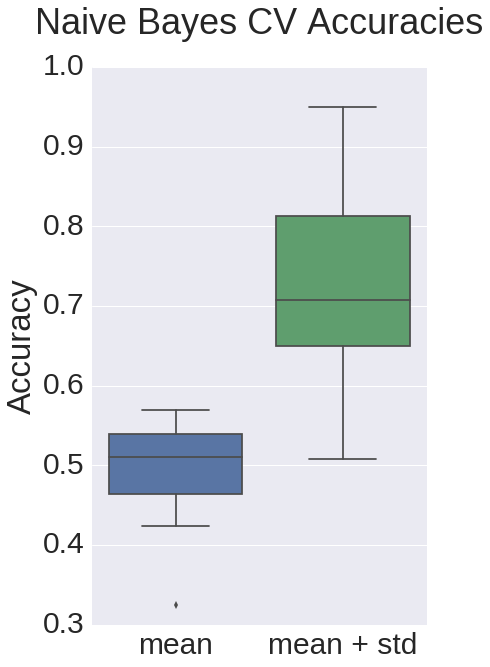

In [42]:
df = df[df['algo'] == 'Naive Bayes']
fig = plt.figure(figsize=(6,10))
ax = sns.boxplot(x="features", y="score", data=df)
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.set_title('Naive Bayes CV Accuracies')
ttl = ax.title
ttl.set_position([.5, 1.05])

#### Distribution of CV Scores
We briefy take a more indepth look of the distribution of the ten different CV scores in the Naive Bayes algorithm, as alluded to in the previous figure.  One sees that in the mean+std set, the individual CV scores span from ~50% accuracy to 95% accuracy! This highlights the instability of the Naive Bayes algorithm, and likely indicates that more data should be used to ensure a more accurate training.  

In [43]:
df2 = pd.DataFrame(cv_scores2, columns=['algo', 'cv_size', 'accuracy'])
df2.head()

,algo,cv_size,accuracy
0,Random Forest,5,0.824551
1,Random Forest,5,0.786600
2,Random Forest,5,0.797020
3,Random Forest,5,0.859627
4,Random Forest,5,0.883706


(0.6, 1)

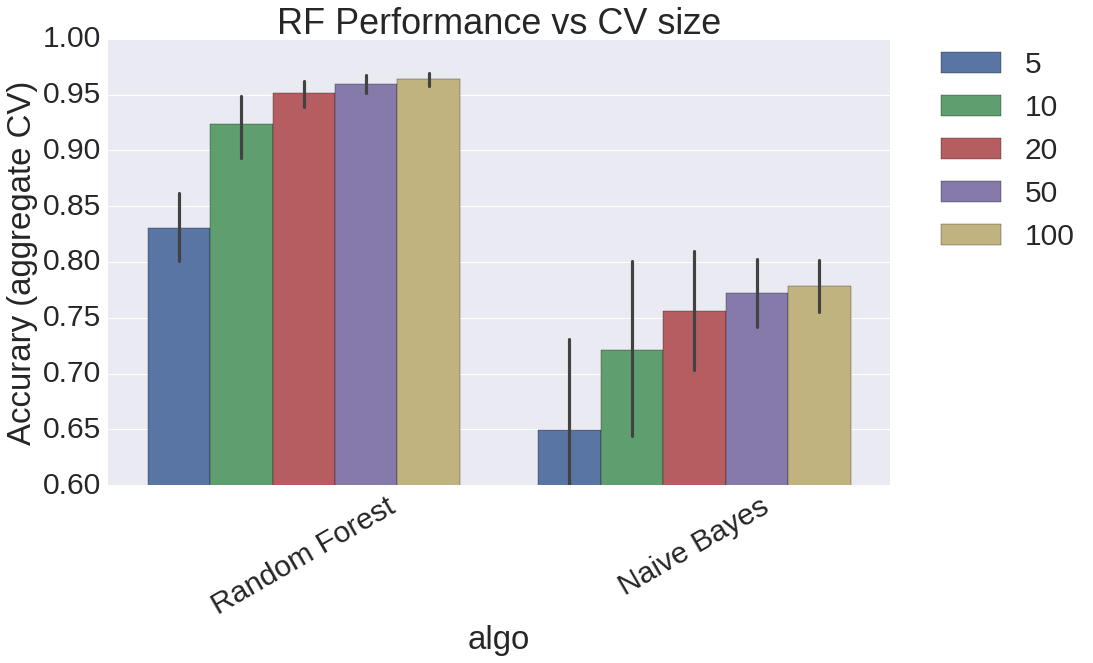

In [44]:
fig = plt.figure(figsize=(14,8))
ax = sns.barplot(x="algo", y="accuracy", hue='cv_size', data=df2)
ax.set_ylabel('Accurary (aggregate CV)')
plt.xticks(rotation=30)
ax.set_title('RF Performance vs CV size')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0.6, 1)

#### Classification Performance vs CV Size
The above chart explores the relationship between the number of cross validation folds and the accuracies of two of the algorithms used.  More cross validation folds results in a larger training set size for each fold, which based on the previous charts may result in performance increases.  The chart confirms this belief, showing a steady increase in accuracy as the number of CV folds increases for both random forests and Naive Bayes - the former reaches 96% accuracy with 20 CV folds.  

## Online Classification
We now turn to implementation of some online classification algorithms.  With the subsampling and feature extraction used so far, online learning is certainly not necessary on a standard computer (the subsampled dataset is only 1.2 MB), and in fact is not recommended. Even the unsampled raw data fits into RAM and can be processed, however will take rather long to train for certain algorithms (especially non-linearn SVM).  However, as a proof of concept, as it may be required with enough data, we present two online learning options for the appropriate dataset.  While we implement the algorithms and show their execution, we sample our 'stream' from the subsampled dataset already in memory.  In a real life application, the time subsampling would have to be performed on records from the raw files on the fly.  This is not difficult to implement, but as it was not required, was not done so.  

Of course not all classification algorithms are adaptable to online learning - many require the complete dataset.  Many algorithms also have online methods discussed in the literature, but do not have easily accesible online implementations (for example random forests).  For this reason, we have chosen to use online Gaussian Naive Bayes, and a linear online Support Vector Machine using stochastic gradient descent.  

Naive Bayes is extremely easy to implement in an online learning setting.  The parameters of the normal distributions governing the classification are simply stored along with the raw values dictating these parameters, and these are simply updated as one sees more samples.  In fact, if one sees say 1000 records, whether they are presented all at once or one at a time makes no difference in the final classifier - the esimated probabililities will be the same.  

On the other hand, linear SVM using stochastic gradient descent is dependent on the intricates of the individual batches. As the algorithm only ever approximates the gradient on small batches (the size of which can be specified by the user) as opposed to the actual gradient, the classifer performance is expected to flucuate based on the batch size and order the samples are presented in.  

### Data Shuffle
The three lines in the below block of code shuffle the data.  Whether this should be performed in the stream setting depends on the context.  If the data is already on disk, shuffling the data likely will lead to better classification earlier in training as more diverse data is seen.  However, in the case where one is collecting data live and immediately entering into a classifier, the data will likely be sorted by time, as is the case of our data so far.  Due to the SGD SVM not working well with unshuffled data, the dataset is shuffled for the next steps. 

In [52]:
data_shuf = data.sample(frac=1).reset_index(drop=True)
y = data_shuf['gt'].values
X = data_shuf.drop(['gt', 'Arrival_Time'], axis=1).values

### Classify on Standard Deviation and Mean
In the below code, we run the online classification using both mean and standard deviation data.  

In [53]:
# some constants for the below code running online classification
classes = np.unique(y)
scores = []
test_accs = []
methods = ['SVM', 'Naive Bayes']
classifiers = [linear_model.SGDClassifier(loss='hinge'), GaussianNB()]
batch_sizes = [1, 10, 20, 50, 100, 500, 1000, 8054]
kf = KFold(8054, n_folds=10)
test_acc = True

In [54]:
# run the online classification - loop over the two classifiers, the seven different batch sizes, and the ten CV folds
# this can also take some time due to the various iterations over parameters 
for l, clf in enumerate(classifiers):
    for batch_size in batch_sizes:
        z = 1 
        for train_index ,test_index in kf:
            if l == 0:
                clf = linear_model.SGDClassifier(loss='hinge')
            else:
                clf = GaussianNB()         
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            i=1
            x_tmp = []
            y_tmp = []
            for entry, gt in zip(X_train, y_train):
                # add the individual records to the batch
                x_tmp.append(entry)
                y_tmp.append(gt)
                # test whether we have seen enough samples to comprise a batch -if so, fit the batch to the existing model
                if i % batch_size == 0 or i == len(X_train) -1:
                    clf.partial_fit(np.array(x_tmp), np.array(y_tmp), classes)
                    x_tmp = []
                    y_tmp = []
                    if test_acc:
                        # gather accuracy data every time we fit a new batch of data
                        test_accs.append((methods[l], i, z, batch_size, clf.score(X_test, y_test)))   
                i += 1 
            # append the CV score after partially fitting the entire dataset
            scores.append((methods[l], z, batch_size, clf.score(X_test, y_test)))
            z += 1 

### Results/Evaluation
As with the online algorithms, the evaluation metric is percentage of records in the test set correctly classified, and ten fold cross validation is used.  

In [55]:
df = pd.DataFrame(test_accs, columns =['algo', 'sample', 'batch', 'batch_size', 'acc'])
df.head()

,algo,sample,batch,batch_size,acc
0,SVM,1,1,1,0.142680
1,SVM,2,1,1,0.191067
2,SVM,3,1,1,0.142680
3,SVM,4,1,1,0.165012
4,SVM,5,1,1,0.209677


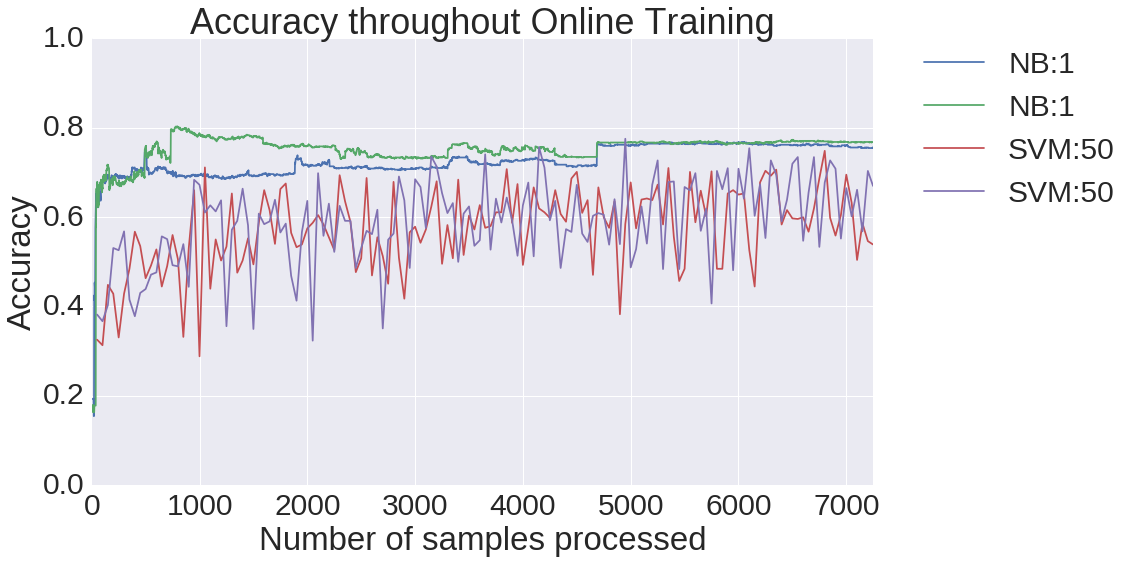

In [56]:
fig, ax = plt.subplots(figsize=(14,8))
#df[(df.algo == 'SVM') & (df.batch == 1)].plot(ax=ax, x='sample', y='acc')
#df[(df.algo == 'Naive Bayes') & (df.batch == 1) & (df.batch_size == 1)].plot(ax=ax, x='sample', y='acc')
df[(df.algo == 'Naive Bayes') & (df.batch == 1) & (df.batch_size == 1)].plot(ax=ax, x='sample', y='acc', label='NB:1')
df[(df.algo == 'Naive Bayes') & (df.batch == 4) & (df.batch_size == 1)].plot(ax=ax, x='sample', y='acc', label='NB:1')
#df[(df.algo == 'Naive Bayes') & (df.batch == 3) & (df.batch_size == 1)].plot(ax=ax, x='sample', y='acc')
#df[(df.algo == 'Naive Bayes') & (df.batch == 4) & (df.batch_size == 1)].plot(ax=ax, x='sample', y='acc')
df[(df.algo == 'SVM') & (df.batch == 3) & (df.batch_size == 50)].plot(ax=ax, x='sample', y='acc', label='SVM:50')
df[(df.algo == 'SVM') & (df.batch == 5) & (df.batch_size == 50)].plot(ax=ax, x='sample', y='acc', label='SVM:50')

plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Number of samples processed')
ax.set_ylabel('Accuracy')
plt.title('Accuracy throughout Online Training')

#### Accuracy Over Training Lifetime
The above chart displays the accuracy of the online algorithms, evaluated on the entire test set immediately after a new batch of data is fit to the model.  The number in the legend refers to the batch size that is plotted. For each algoritm, two separate CV folds are plotted to show any stochasticity in the data set splitting process.  

The Naive Bayes algorithm takes very few samples to reach high accuracy.  If the data were not shuffled, it naturally would take longer.  The higher green accuracy around sample 800 is likely due to chance, and overtime the accuracy evens out.  This number is equal to the online version of the algorithm, which is expected as discussed above.  There are slight fluctuations as the parameters of the gaussiasns are updated over time, and there is some stochasticity in the dataset split (difference between blue and green curves), but both converge to the same accuracy.  

The online SVM performs worse than the online Naive Bayes, and is a significant drop in performance from the offline linear SVM. The curves do show a general upward trend in accuracy, but as one sees, each update causes the accuracy to oscillate, sometimes with rather large magnitudes.  Additionally, there is more stochasticy induced by dataset split (purple vs red).  

In [57]:
#batch_sizes = [1] * 10 + [10] * 10 + [20] * 10 + [50] * 10
#df['batch_size'] = batch_sizes * 2

#batch_sizes = [500]*10 + [1000]*10
#df2['batch_size'] = batch_sizes 

#df2 = pd.DataFrame(scores2, columns =['algo', 'batch', 'acc'])
#df = pd.concat([df, df2])

#df['iter'] = range(1, len(df)+1)
#df2 = pd.DataFrame(test_accs2, columns =['algo', 'sample', 'batch', 'batch_size', 'acc'])
#df = pd.concat([df, df2])

In [58]:
df = pd.DataFrame(scores, columns =['algo', 'batch', 'batch_size', 'acc'])
df.head()

,algo,batch,batch_size,acc
0,SVM,1,1,0.513648
1,SVM,2,1,0.552109
2,SVM,3,1,0.552109
3,SVM,4,1,0.598015
4,SVM,5,1,0.554037


(0, 0.7)

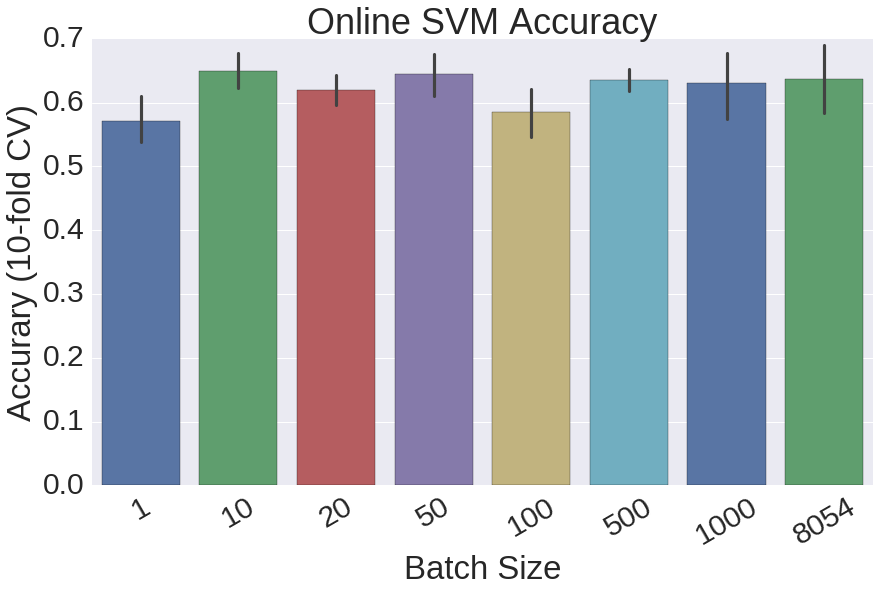

In [76]:
fig = plt.figure(figsize=(14,8))

ax = sns.barplot(x="batch_size", y="acc", data=df[df.algo == 'SVM'])
ax.set_ylabel('Accurary (10-fold CV)')
ax.set_xlabel('Batch Size')
plt.xticks(rotation=30)
ax.set_title('Online SVM Accuracy')
plt.ylim(0, 0.7)

#### Linear SVM Accuracy
We then looked at whether the batch size affects the final accuracy of the online SVM (again, we know it won't affect the Naive Bayes algorithm, hence why it is ignored here).  One would expect that with larger batches, the classifier will be more accurate, as the gradient calculated per batch will be more accurate and less prone to noise.  Generally this is the case; batch size of 1 is the least accurate.  Note that a batch size of 8054 corresponds to seeing all of the data at once.

Overall, the oscillating nature of the accuracy as the algorithm updates per batch seen in the previous chart (the accuracy always oscillates between increasing/decreasing - one would expect at least some iterations where the accuracy increases or decreases twice in a row, if not more), leads us to believe there are parameters in the online linear SVM that need to be fiddled with in order to optimize for our data.  As a linear SVM performs sufficiently well in the offline setting, it is not the nature of the model that is the problem.

## Conclusion
The above analysis shows that using just the mean and standard deviation extracted from 2s windows of the original data results in rather accurate offline classification using a number of different algorithms.  The analysis also showed that after subsampling, more data helps with classification performance, plateauing around 95% accuracy for the best classifiers (SVM(rbf), Nearest Neighbors, Random Forests).  Online classification of 2s subsampled data performs significantly worse, with the best option presented being Gaussian Naive Bayes, achieving an accuracy of 72%.  Online linear SVMs using stochastic gradient descent were less accurate.  

### Future Work
A number of different options exist to improve the results presented above.  Some of these are presented below.  
    - Filter out potentially noisy data.  In the above analysis we assumed 2s subsampling would make individual noisy measurements obsolete, however an outlier analysis before subsampling could be helpful. 
    
    - Experiment with different time window lengths for subsampling.  
    
    - Further features could be extracted from the data as described by Figo et al. in his paper ‘Preprocessing techniques for context recognition from accelerometer data'  
    
    - Instead of using a standard 10 fold cross evaluation technique, a leave-one-user-out technique wherein data for one user is left out as the validation set can be used.  
    
    - Perform self-learning on the records classified as 'null' in order to increase trainings set sizes.  
    
    - Incorporate device information in classification (although then not as generalizeable).  
    
    - Use watch data (probababy should have been done anyway).   
    
    - Test to see if training works on only device (as opposed to aggregate of all devices), as this is more likely what will be see in a practical setting 

## Citations and Links
**Bibliography**:  

    [1] Allan Stisen, Henrik Blunck, Sourav Bhattacharya, Thor Siiger Prentow, Mikkel Baun Kjærgaard, Anind Dey, Tobias Sonne, and Mads Møller Jensen "Smart Devices are Different: Assessing and Mitigating Mobile Sensing Heterogeneities for Activity Recognition" In Proc. 13th ACM Conference on Embedded Networked Sensor Systems (SenSys 2015), Seoul, Korea, 2015   

    [2] Figo, D., Diniz, P. C., Ferreira, D. R., & Cardoso, J. M. (2010). Preprocessing techniques for context recognition from accelerometer data. Pers Ubiquit Comput Personal and Ubiquitous Computing, 14(7), 645-662. doi:10.1007/s00779-010-0293-9

**Data set download location**:   
http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29

**Paper on feature extraction**:  
http://link.springer.com/article/10.1007/s00779-010-0293-9